# CPI index forecasting

**Author:** Joana Simões, joanasimoes@student.dei.uc.pt

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.signal as scs
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import statsmodels.tsa.stattools as st
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn import metrics

from utils import * 

In [5]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

## Introduction

This notebook presents an analysis of the CPI Index from Norway from 1990 until the most recent update (August, 2022). 

NOTE: Throughout the analysis, a significance level of 95% was chosen for all the tests developed.

## Read data

In [6]:
df = pd.read_csv(os.path.join('CPITimeSeries', 'time_series_data.csv'), index_col='Date')

In [7]:
df.index = pd.to_datetime(df.index)

In [8]:
# select data from 1990 until now
df = df.loc[df.index >= '1990-01-01']

## Select the data from Norway

In [9]:
country = 'Norway'

## Time series overview 

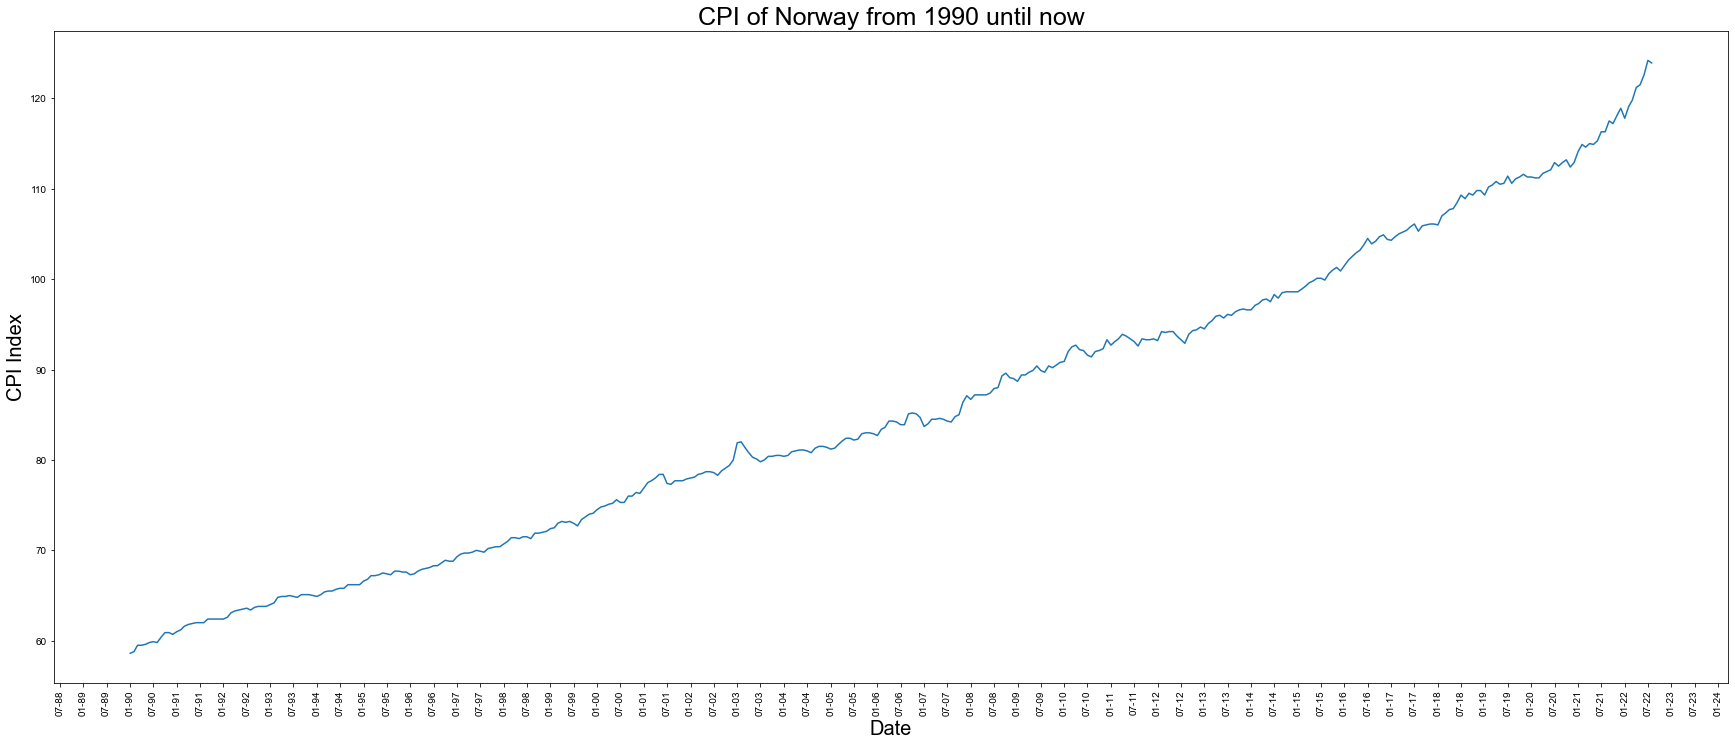

In [10]:
fig, ax = plt.subplots(figsize=(30, 12))
sns.set(font_scale=1.5, style="whitegrid")
plt.plot(df.index, df[country])

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation='vertical')
date_form = DateFormatter("%m-%y")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontdict=dict(size=20))
plt.ylabel('CPI Index', fontdict=dict(size=20))
plt.title(f'CPI of {country} from 1990 until now', fontdict=dict(size=25))
plt.savefig(os.path.join('images', 'original-ts.png'))
plt.show()


In a first analysis of the time series (TS), it's clearly seen a increasing trend of the CPI values over time. On a closer look, the TS appears to have a repetition (seasonality) every 6 months. With the increasing trend and seasonality every 6-months, it can be concluded that the original TS is not stationary. Therefore, it should be transformed to become stationary in order to apply forecasting models.

From the TS, it can also be concluded that there is and rapid increasing in the last 2-3 years, which will impact the final results as this exponential increasing is just the final part of the TS

## Divide the time series into train and test

In [11]:
train_ratio = 0.8
split_index = int(len(df) * train_ratio)

# Split the time series data
train_data = df[:split_index]
test_data = df[split_index:]
months_dates = months = np.arange(len(df))
months = months_dates[:split_index]
months_test = months_dates[split_index:]

In [12]:
ts = train_data[country]
ts_test = test_data[country]

## Period

In [13]:
period = 12

## Linear models for stationary Time series

### Transform time series

In [14]:
transformer = ConvertIntoStationary(order_trend=1, filter_freq=2.2, period=period)

In [15]:
trend_seasonal_adjusted = transformer.convert_train(months, ts)

In [16]:
test_trend_seasonal_adjusted = transformer.convert_test(months_test, ts_test)

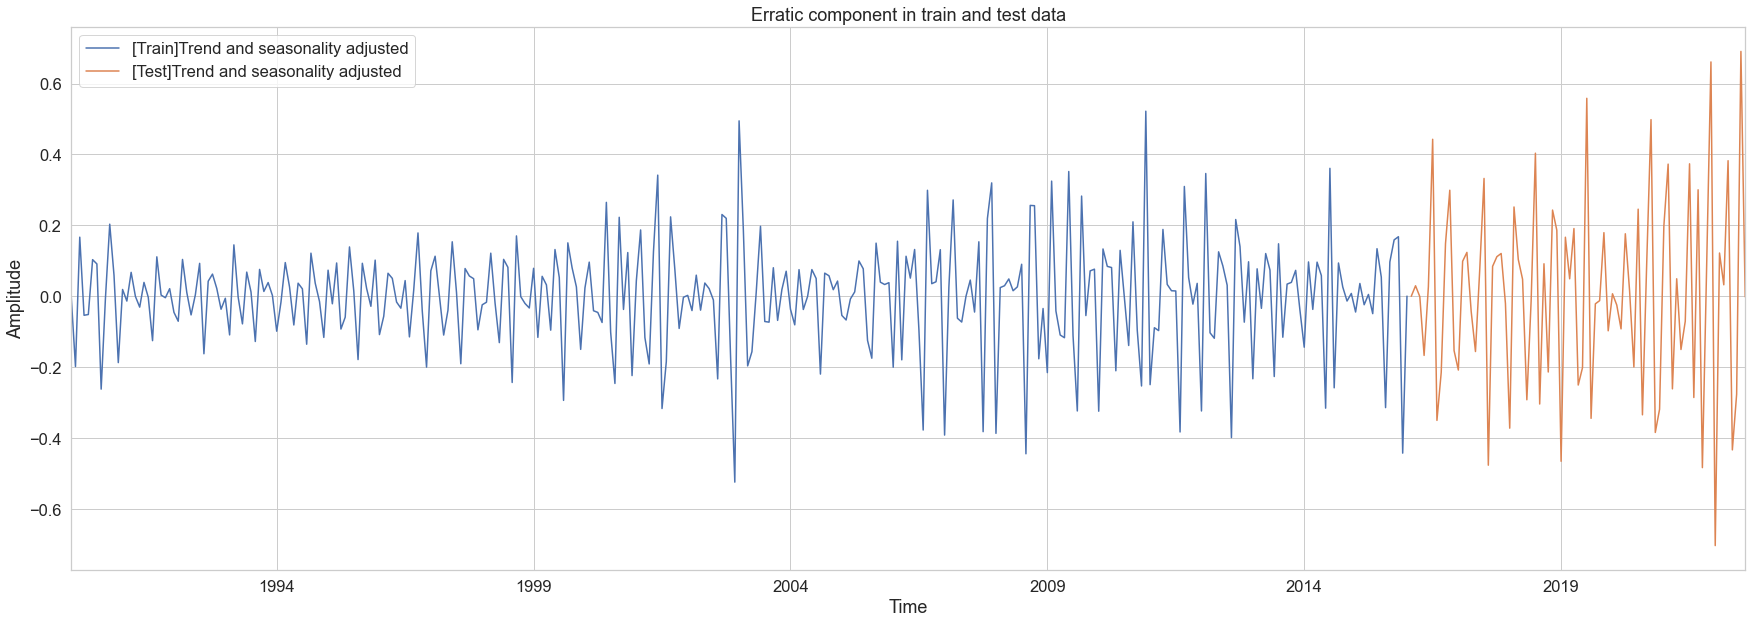

In [17]:
fig, ax = plt.subplots(figsize=(30, 10))
trend_seasonal_adjusted.plot(ax=ax, legend=True)
test_trend_seasonal_adjusted.plot(ax=ax, legend=True)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Erratic component in train and test data')
plt.savefig(os.path.join('images', 'train_test_erratic.png'))

### Trend and seasonal adjusted by model-fitting and filtering

In [18]:
adf_test(trend_seasonal_adjusted)

ADF Statistic: -17.221312
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


Based on the ADF test, given the p-value of 0.0, the transformed TS is stationary.

### Trend and seasonal adjusted test

In [19]:
adf_test(test_trend_seasonal_adjusted)

ADF Statistic: -7.344564
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


By the Dickey-Fuller test, after differencing the resulted TS is stationary. However, the ADF statistic most closer to the critical values than when the TS is decomposed by model-fitting and filtering. 

### ACS to see stationary

In [20]:
def auto_covarience_aux(ts, T=0):
    N = len(ts)
    mean = ts.mean()
    cov_coef = 0
    for n in range(N-T-1): ## Não estaremos a retirar um a mais
        cov_coef += (ts[n] - mean) * (ts[n+T]-mean)
    return cov_coef / N


def auto_covarience(ts, T=0):
    return auto_covarience_aux(ts, T) / auto_covarience_aux(ts)


def correlogram(ts, max_T, twoside=False):
    N = len(ts)
    if twoside:
        corrl = np.zeros(2 * max_T + 1)
        index = np.arange(max_T + 1)
        index = np.concatenate((-np.flip(index[1:]), index), axis=0)
    else:
        corrl = np.zeros(max_T)
        index = np.arange(max_T)

    for i in range(max_T):
        if twoside:
            corrl[max_T + i] = auto_covarience(ts, i)
            corrl[max_T - i] = corrl[max_T + 1]
        else:
            corrl[i] = auto_covarience(ts, i)
    
    d = {'ACS':corrl, 'upper_CB':np.ones(max_T)*(1.96/np.sqrt(N)),'lower_CB':-np.ones(max_T)*(1.96/np.sqrt(N))}
    return pd.DataFrame(data=d, index=index)

In [21]:
def plot_correlogram(ts, title, period=12):
    corrl = correlogram(ts, len(ts))
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.stem(corrl.index, corrl.ACS, label='ACS')
    ax.plot(corrl.index, corrl.upper_CB, linestyle='--', color='r', linewidth=2, label='+/-1.96/sqrt(N)'),
    ax.plot(corrl.index, corrl.lower_CB, linestyle='--', color='r', linewidth=2),
    plt.title(title, fontdict=dict(size=25))
    plt.legend()
    ax.set_xlim([-0.5, period+0.5])
    plt.ylabel('Autocorrelation')
    plt.xlabel('T')

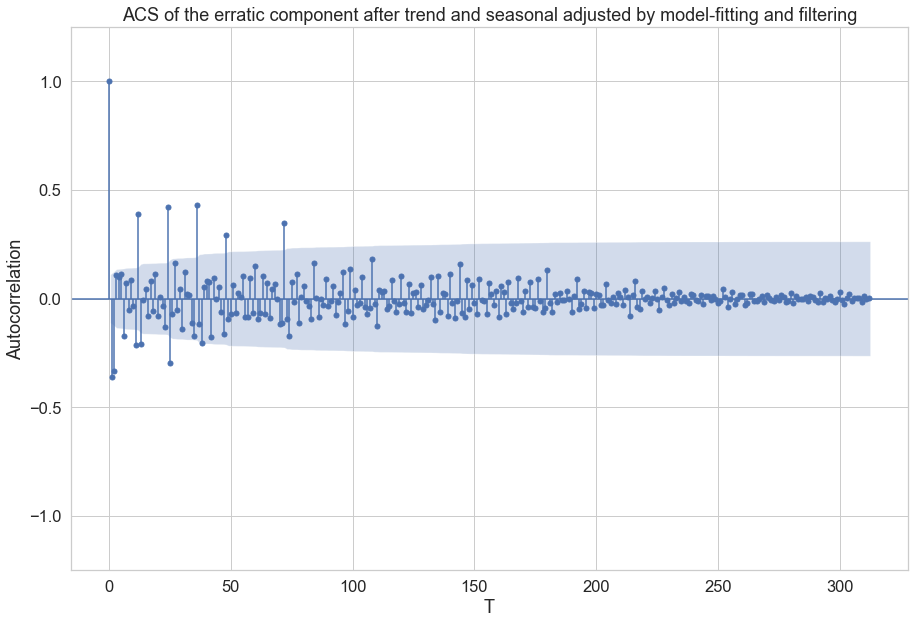

In [22]:
# plot_correlogram(trend_seasonal_adjusted, 'Erratic Component after trend and seasonality adjusted by model-fitting and filtering')
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_acf(trend_seasonal_adjusted, alpha=0.05, ax=ax, lags=len(trend_seasonal_adjusted)-1)
plt.ylabel('Autocorrelation')
plt.xlabel('T')
ax.set_ylim([-1.25, 1.25])
plt.title('ACS of the erratic component after trend and seasonal adjusted by model-fitting and filtering')
plt.savefig(os.path.join('images', 'acs_additive_model.png'))
plt.show()


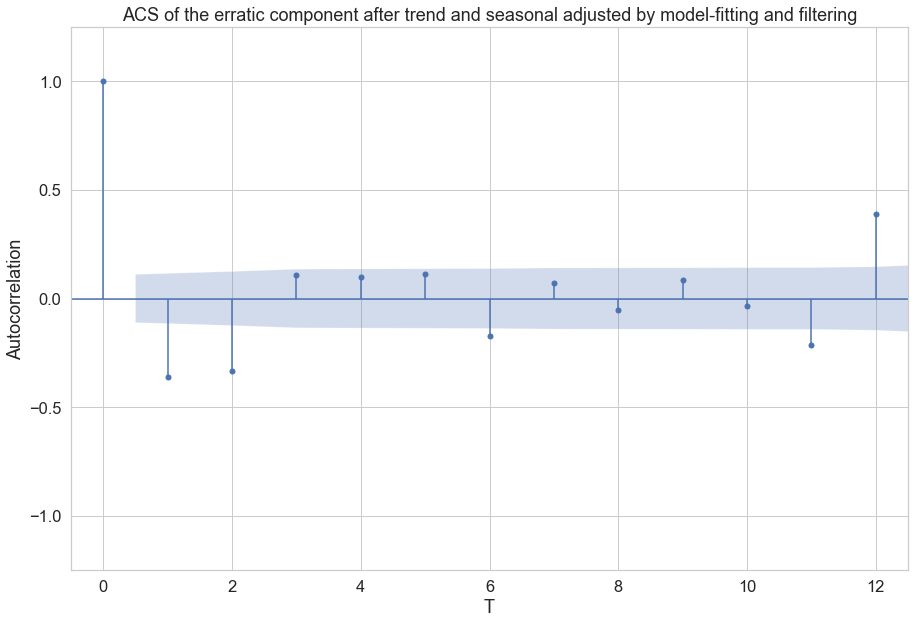

In [23]:
# plot_correlogram(trend_seasonal_adjusted, 'Erratic Component after trend and seasonality adjusted by model-fitting and filtering')
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_acf(trend_seasonal_adjusted, alpha=0.05, ax=ax, lags=len(trend_seasonal_adjusted)-1)
plt.ylabel('Autocorrelation')
plt.xlabel('T')
ax.set_ylim([-1.25, 1.25])
ax.set_xlim([-0.5, period + 0.5])
plt.title('ACS of the erratic component after trend and seasonal adjusted by model-fitting and filtering')
plt.savefig(os.path.join('images', 'acs_additive_model.png'))
plt.show()


It can be seen that there is a rapid decreasing the the ACS, which indicates that the erratic component is stationary. 
Looking at the ACS for the first 12 lags (period=12), there are 2 significant value outside the unit root, therefore, a MA of order 2 can be used to describe the process.

### Assessing the underlying process of the stationary TS

#### PACS

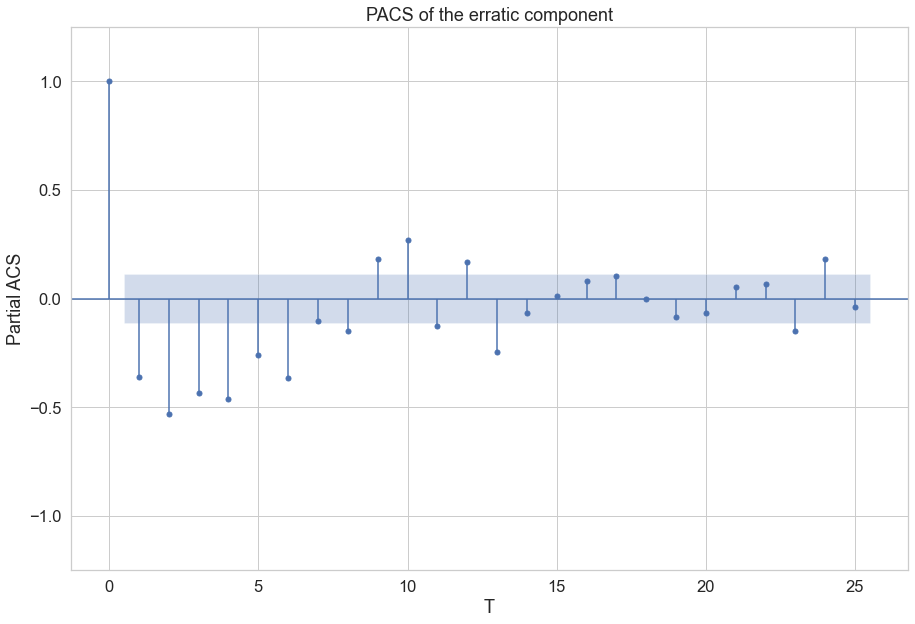

In [24]:
fog, ax = plt.subplots(1, figsize=(15, 10))
plot_pacf(trend_seasonal_adjusted, alpha=0.05, ax=ax)
ax.set_ylim([-1.25, 1.25])
plt.xlabel('T')
plt.ylabel('Partial ACS')
plt.title('PACS of the erratic component')
plt.savefig(os.path.join('images', 'pacs_plot.png'))
plt.show()

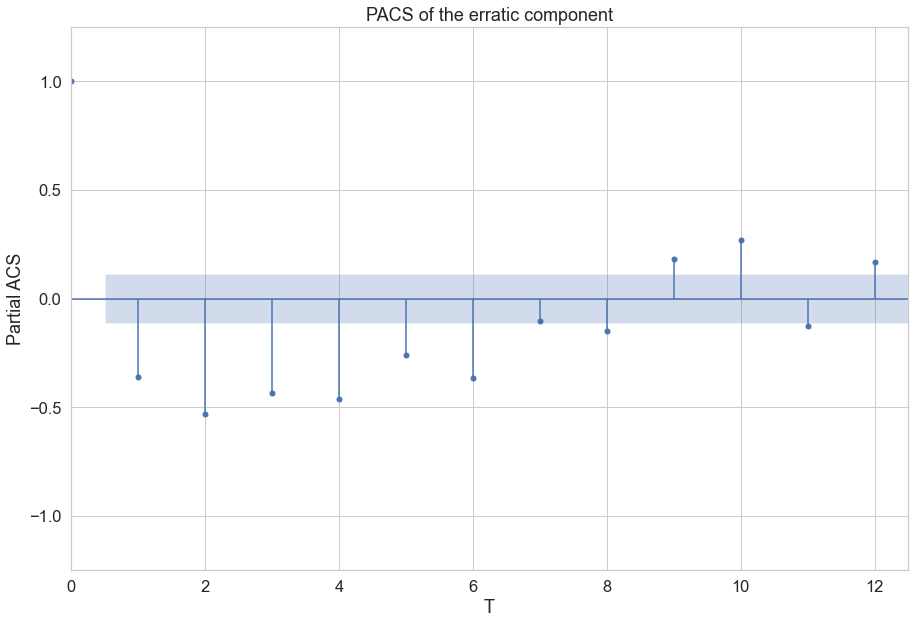

In [25]:
fog, ax = plt.subplots(1, figsize=(15, 10))
plot_pacf(trend_seasonal_adjusted, alpha=0.05, ax=ax)
ax.set_ylim([-1.25, 1.25])
ax.set_xlim([0, 12.5])
plt.xlabel('T')
plt.ylabel('Partial ACS')
plt.title('PACS of the erratic component')
plt.savefig(os.path.join('images', 'pacs_plot.png'))
plt.show()

Looking at the PACS graph, it can be concluded that it should be use a AR model of order 6 from the problem, as there are clearly 6 significant autocorrelation values. 

In [26]:
def pacs(serie,max_lag=25):
    N=serie.size
    pcorrl=np.zeros(max_lag+1)
    ix=np.array(range(max_lag+1))
    pcorrl[0]=1
    for p in range(1,max_lag+1):
        model = ARIMA(serie, order=(p,0,0))
        model_fit = model.fit()
        pcorrl[p]=model_fit.arparams[-1]
        
    d = {'PACS':pcorrl, 'upsig':np.ones(max_lag+1)*(1.96/np.sqrt(N)),'dnsig':-np.ones(max_lag+1)*(1.96/np.sqrt(N))}
    corrl=pd.DataFrame(data=d,index=ix)
    return corrl

In [27]:
pcorrl = pacs(trend_seasonal_adjusted)

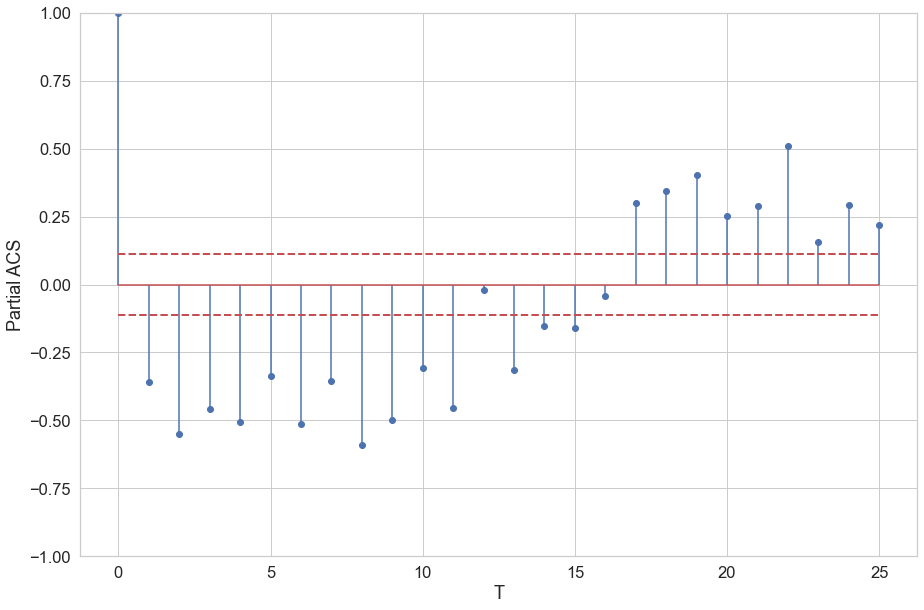

In [28]:
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.stem(pcorrl.index,pcorrl['PACS'])
ax.plot(pcorrl.index,pcorrl['upsig'],linestyle='--', color='r', linewidth=2)
ax.plot(pcorrl.index,pcorrl['dnsig'],linestyle='--', color='r', linewidth=2)
ax.set_ylim([-1, 1])
plt.xlabel('T')
plt.ylabel('Partial ACS')
plt.show()

From the PACS plot, it can also be concluded that the time series presents a autoregressive component, concluding that should be use a ARMA model.

In order to find the best order for the model, it will be use grid search, varying the q order from 0 to 2 and the p order from 0 to 11. To evaluate the different models, it will be use the Akaike's Information Criterion (AIC) and Bayesian Information Criterion (BIC) metrics as using the residuals error does not penalize the complexity of the model.

### Looking for the best Linear model for stationary time series

In [29]:
max_q = 2
max_p = 11

In [26]:
residuals = pd.DataFrame(columns=['p', 'q', 'residual', 'aic', 'bic'])
for order_p in range(0,  max_p+1):
    for order_q in range(0,  max_q+1):
        model = ARIMA(trend_seasonal_adjusted, order=(order_p, 0, order_q))
        model_fit = model.fit()
        residual = np.sum(model_fit.resid**2)
        aux = {
            'p' : [order_p],
            'q' : [order_q],
            'residual' : [residual],
            'aic' : [model_fit.aic],
            'bic' : [model_fit.bic]
        }
        print('P-', order_p, '\tQ-', order_q, '\tResiduals-', residual, '\tAIC-', model_fit.aic, '\tBIC-', model_fit.bic)
        residuals = pd.concat([residuals, pd.DataFrame(aux)], ignore_index=True)
        

        

P- 0 	Q- 0 	Residuals- 7.257353204977381 	AIC- -285.93532182312845 	BIC- -278.44291544204816
P- 0 	Q- 1 	Residuals- 3.1487410602051384 	AIC- -543.795692275287 	BIC- -532.5570827036665
P- 0 	Q- 2 	Residuals- 1.658832174719843 	AIC- -742.107622839121 	BIC- -727.1228100769604
P- 1 	Q- 0 	Residuals- 6.315180780679298 	AIC- -327.32262637783214 	BIC- -316.0840168062117
P- 1 	Q- 1 	Residuals- 3.0533797610286686 	AIC- -551.3318421175709 	BIC- -536.3470293554103
P- 1 	Q- 2 	Residuals- 3.120985077877328 	AIC- -543.0045196770525 	BIC- -524.2735037243517
P- 2 	Q- 0 	Residuals- 4.463394994376657 	AIC- -434.0538115576324 	BIC- -419.06899879547177
P- 2 	Q- 1 	Residuals- 2.09133799858414 	AIC- -669.1389819054245 	BIC- -650.4079659527238
P- 2 	Q- 2 	Residuals- 2.69792493768753 	AIC- -587.2682308838087 	BIC- -564.7910117405677
P- 3 	Q- 0 	Residuals- 3.5568937356742607 	AIC- -503.19070065910955 	BIC- -484.4596847064088
P- 3 	Q- 1 	Residuals- 1.7996548503311027 	AIC- -715.988124961624 	BIC- -693.510905818

In [27]:
residuals

,p,q,residual,aic,bic
0,0,0,7.257353,-285.935322,-278.442915
1,0,1,3.148741,-543.795692,-532.557083
2,0,2,1.658832,-742.107623,-727.122810
3,1,0,6.315181,-327.322626,-316.084017
4,1,1,3.053380,-551.331842,-536.347029
5,1,2,3.120985,-543.004520,-524.273504
6,2,0,4.463395,-434.053812,-419.068999
7,2,1,2.091338,-669.138982,-650.407966
8,2,2,2.697925,-587.268231,-564.791012
9,3,0,3.556894,-503.190701,-484.459685


In [28]:
residuals.loc[(residuals.aic == residuals.aic.min())]

,p,q,residual,aic,bic
33,11,0,0.509495,-1120.464889,-1071.764247


In [29]:
lower_p = residuals.loc[residuals.p <= 6]

In [30]:
lower_p.loc[lower_p.aic == lower_p.aic.min()]

,p,q,residual,aic,bic
19,6,1,1.142139,-865.038881,-831.323052


In [31]:
best = residuals.loc[residuals.aic == residuals.aic.min()]
best

,p,q,residual,aic,bic
33,11,0,0.509495,-1120.464889,-1071.764247


In [32]:
best_p = best.p.values[0]
best_q = best.q.values[0]

In [34]:
model = ARIMA(trend_seasonal_adjusted, order=(best_p, 0, best_q))
model = model.fit()

In [47]:
preds = model.predict(start=len(months), end=len(months_dates)-1)
preds.name = 'Predicted Test'

<Axes: xlabel='Date'>

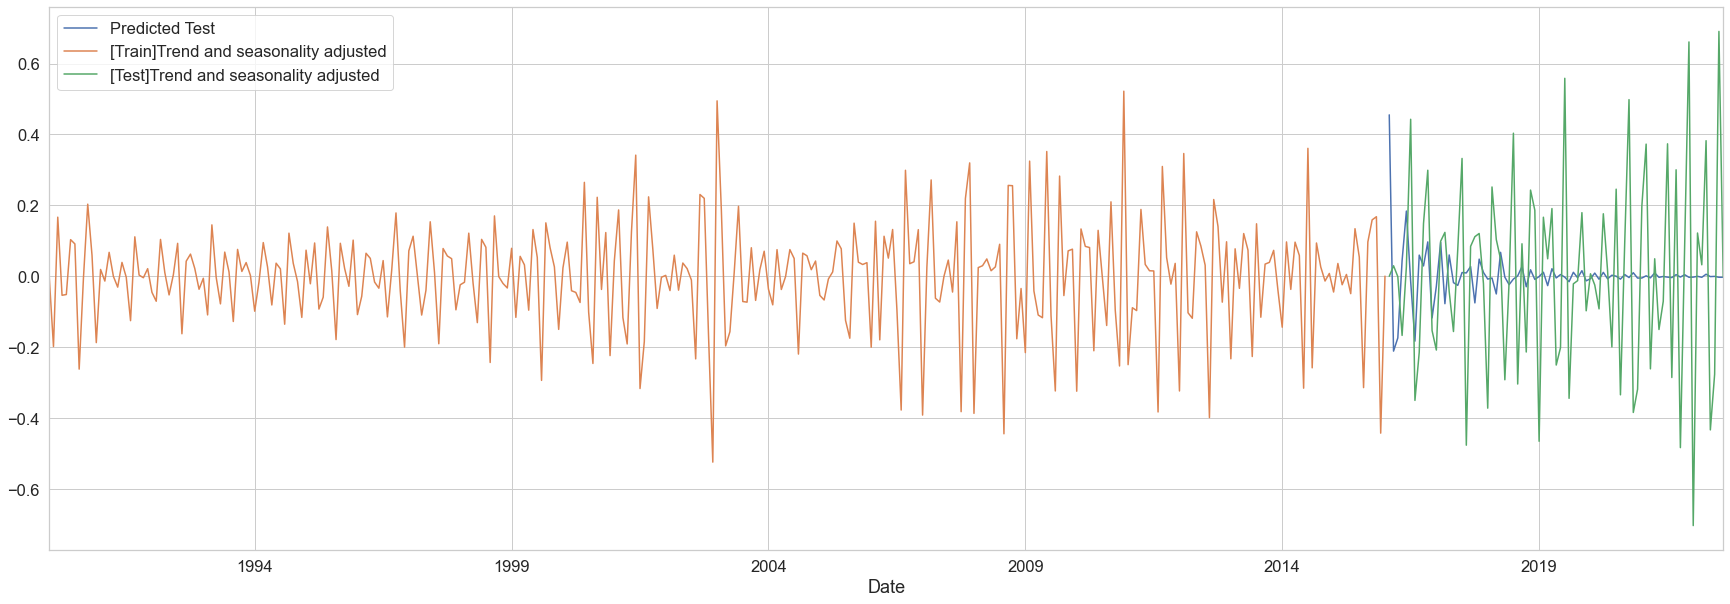

In [48]:
ax = preds.plot(figsize=(30, 10), legend=True)
trend_seasonal_adjusted.plot(ax=ax, legend=True)
test_trend_seasonal_adjusted.plot(ax=ax, legend=True)

## Linear models from non-stationary time series

For non-stationary time series, and since the TS has a seasonality, it will be use a SARIMA model. To found the best parameters of the model, it will be used grid-search and the models will be evaluated by the AIC and BIC values. 

### SARIMA model

(p, d, q) X (P, D, Q) S

S = seasonality period
d = for applying differencing - since it has a trend, use a d = 1
D = 1 -> apply first differencing for seasonal component based on the period

<Axes: title={'center': 'Original Train Data'}, xlabel='Date'>

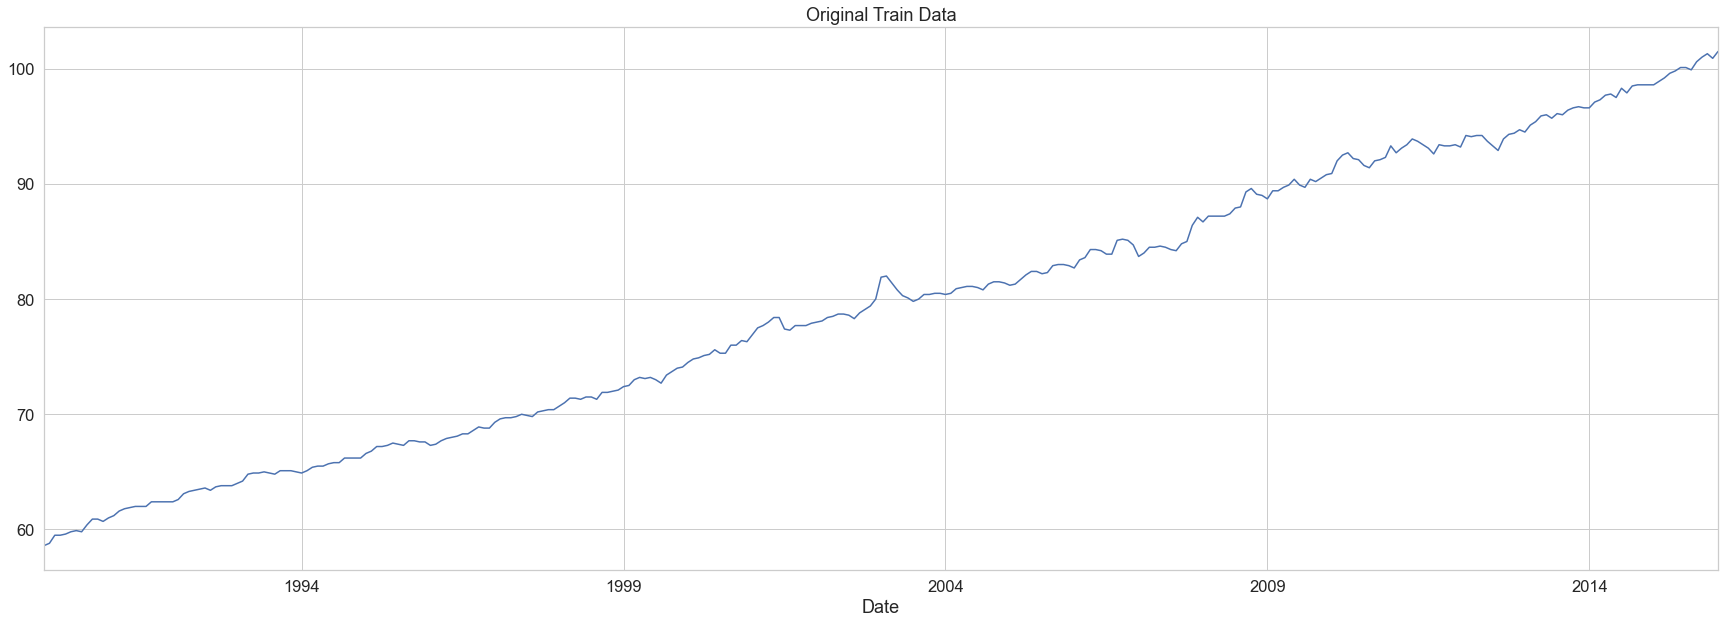

In [30]:
ts.plot(figsize=(30, 10), title='Original Train Data')

As there is a clear trend, it will be applied a first order simple differencing.

In [31]:
trend_diff_adjusted = ts.diff()

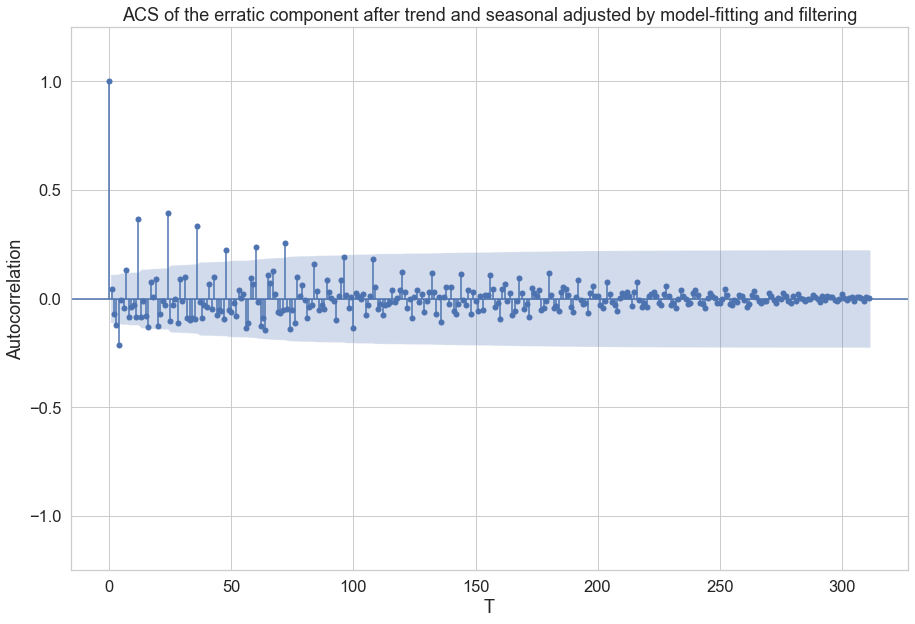

In [32]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_acf(trend_diff_adjusted.dropna(), alpha=0.05, ax=ax, lags=len(trend_diff_adjusted.dropna())-1)
plt.ylabel('Autocorrelation')
plt.xlabel('T')
ax.set_ylim([-1.25, 1.25])
plt.title('ACS of the erratic component after trend and seasonal adjusted by model-fitting and filtering')
plt.savefig(os.path.join('images', 'acs_additive_model.png'))
plt.show()


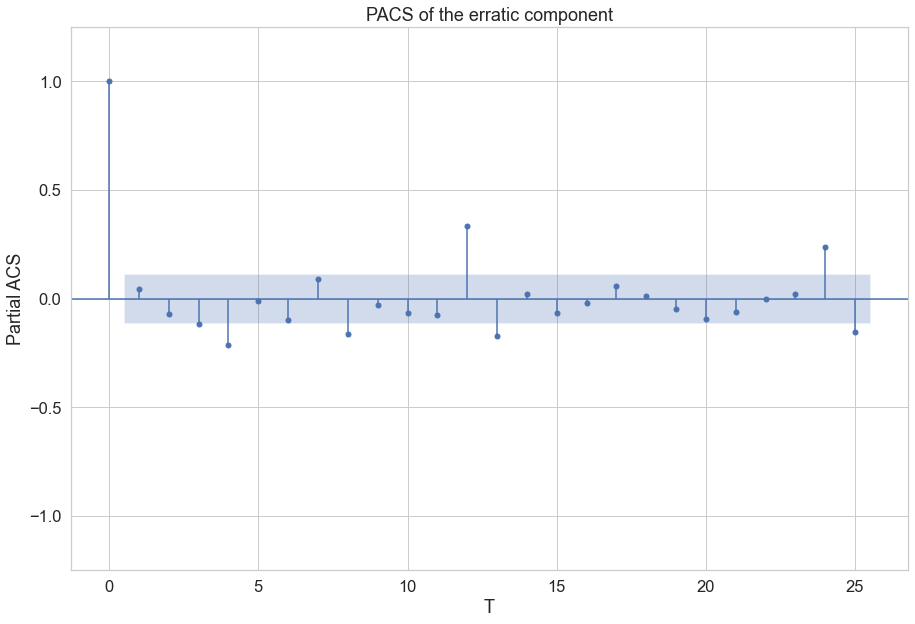

In [34]:
fog, ax = plt.subplots(1, figsize=(15, 10))
plot_pacf(trend_diff_adjusted.dropna(), alpha=0.05, ax=ax)
ax.set_ylim([-1.25, 1.25])
plt.xlabel('T')
plt.ylabel('Partial ACS')
plt.title('PACS of the erratic component')
plt.savefig(os.path.join('images', 'pacs_plot.png'))
plt.show()

From the ACS it can be confirmed that seasonality is present, since there are ACS peaks at 12, 24, 36, etc. With this in mind, first-order seasonal differencing with S=12 will be applied as previously referenced. 

In [35]:
seasonal_adjusted = trend_diff_adjusted.diff(period)

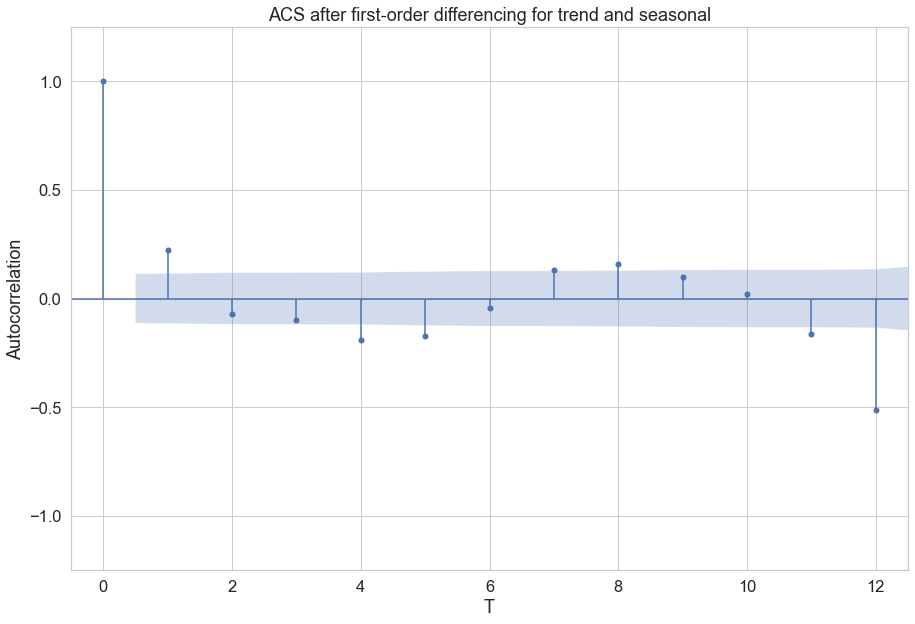

In [36]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_acf(seasonal_adjusted.dropna(), alpha=0.05, ax=ax, lags=len(seasonal_adjusted.dropna())-1)
plt.ylabel('Autocorrelation')
plt.xlabel('T')
ax.set_ylim([-1.25, 1.25])
ax.set_xlim([-0.5, 0.5+period])
plt.title('ACS after first-order differencing for trend and seasonal')
plt.savefig(os.path.join('images', 'acs_additive_model.png'))
plt.show()


Looking at the ACS for T < 12, at lag 1, the ACS fall outside the unit root, meaning a q = 1.

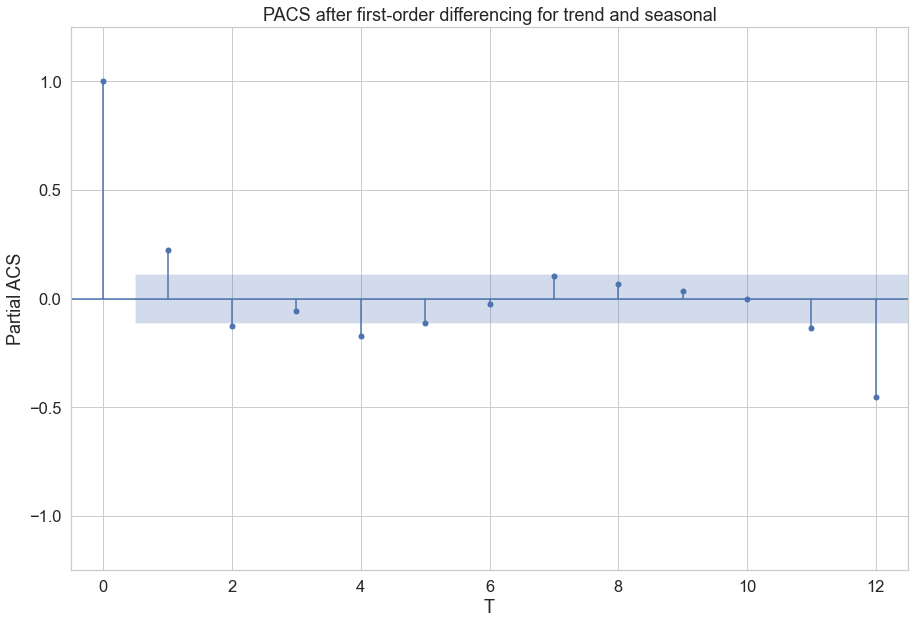

In [37]:
fog, ax = plt.subplots(1, figsize=(15, 10))
plot_pacf(seasonal_adjusted.dropna(), alpha=0.05, ax=ax)
ax.set_ylim([-1.25, 1.25])
ax.set_xlim([-0.5, 0.5+period])
plt.xlabel('T')
plt.ylabel('Partial ACS')
plt.title('PACS after first-order differencing for trend and seasonal')
plt.savefig(os.path.join('images', 'pacs_plot.png'))
plt.show()

The first-order seasonal differencing seems appropriated to transform the TS into stationary, as previously seen in the ts-analysis notebook and confirmed by the ADF test. Therefore, a D=1 should be applied.
Looking at the PACS for T<12, for lag 1 and 2, the PACS fall out the unit root, so we can estimate as p=2.

Looking at the lags 12, 24, and 36, we can estimate the Q=1, as there is one significant value at lag 12.

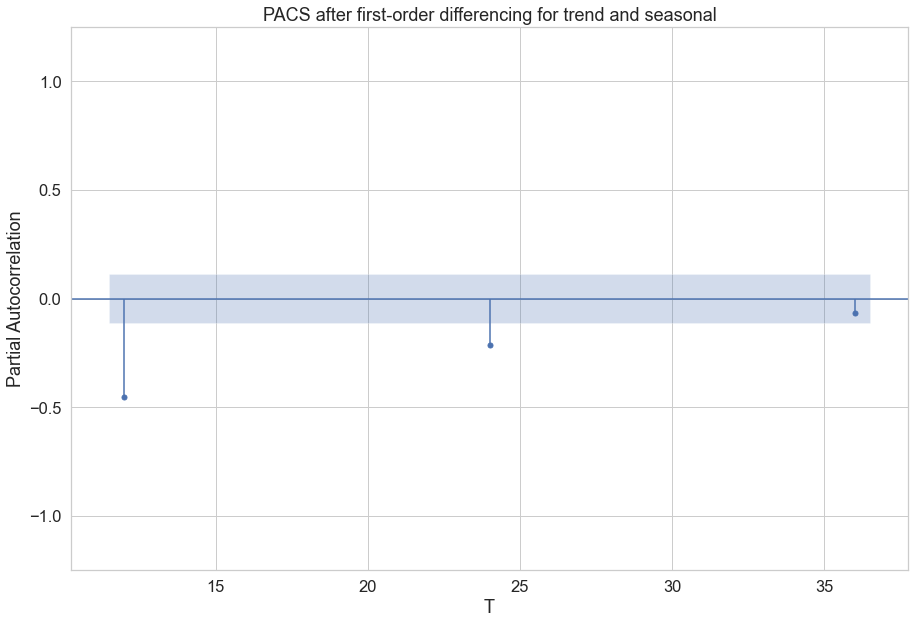

In [38]:
fig, ax = plt.subplots(1, figsize=(15, 10))
plot_pacf(seasonal_adjusted.dropna(), alpha=0.05, ax=ax, lags=[12, 24, 36] )
plt.ylabel('Partial Autocorrelation')
plt.xlabel('T')
ax.set_ylim([-1.25, 1.25])
plt.title('PACS after first-order differencing for trend and seasonal')
plt.show()

From the PACS for lags 12, 24, and 36, it can be estimated that P=2 as there is two significant values

With all values estimated, the SARIMA model must be :

(p, d, q) X (P, D, Q) S with
d = 1, D = 1, S = 12, p = 2, q = 1, Q = 1, P=2

In [39]:
d = 1
D = 1
S = period
p = 2
q = 1
Q = 1
P = 2

In [40]:
model = ARIMA(ts, order=(p, d, q), seasonal_order=(P, D, Q, S))
model_fitted = model.fit()

In [41]:
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                           Norway   No. Observations:                  313
Model:             ARIMA(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -57.314
Date:                          Wed, 15 Nov 2023   AIC                            128.629
Time:                                  15:32:33   BIC                            154.555
Sample:                              01-01-1990   HQIC                           139.005
                                   - 01-01-2016                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9730      0.105      9.244      0.000       0.767       1.179
ar.L2         -0.2475      0.045     -5.449      0.000      -0.337      -0.158
ma.L1         -0.8181      0.109     -7.523      0.000      -1.031      -0.605
ar.S.L12       0.1472      0.062      2.368      0.018       0.025       0.269
ar.S.L24       0.2148      0.058      3.673      0.000       0.100       0.329
ma.S.L12      -0.9255      0.062    -14.819      0.000      -1.048      -0.803
sigma2         0.0814      0.004     18.800      0.000       0.073       0.090
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               303.68
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               6.30   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
preds = model_fitted.predict(start=len(ts), end=(len(ts) + len(ts_test)-1))
preds.name = 'Predicted TS'

<Axes: xlabel='Date'>

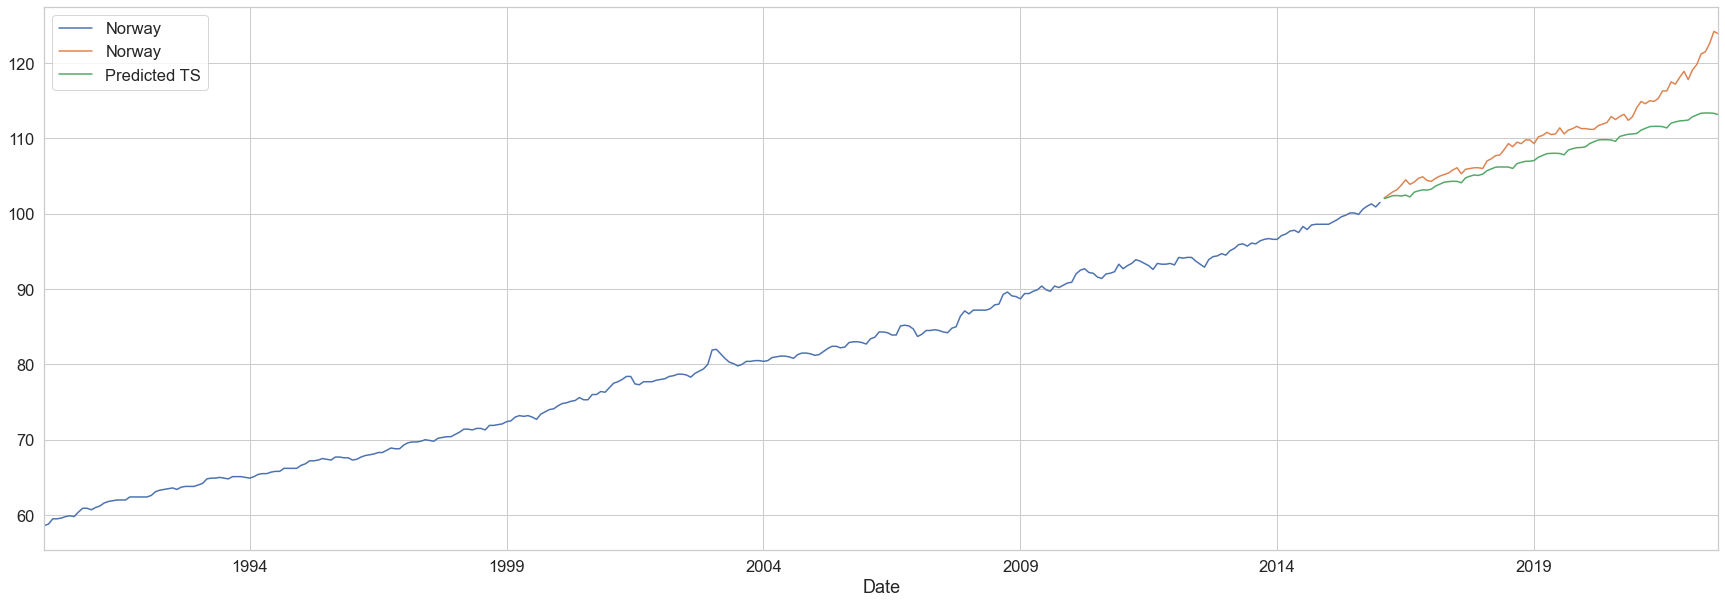

In [43]:
ax = ts.plot(figsize=(30, 10), legend=True)
ts_test.plot(ax=ax, legend=True)
preds.plot(ax=ax, legend=True)

In [44]:
metrics_summary(ts_test, preds)

MAPE: 0.025636627401052735
MAE: 2.9265787804619037
MSE: 13.462075292220362
RMSE: 3.6690700854876517
R2: 0.5359757692023833


As the model may not have the best appropriate parameters, it will be used grid-search to find the best parameters. The evaluation will take into consideration the AIC wit the train data and the MAPE error in the validation set.

In [45]:
# split train data to evaluate the models
ts_train, ts_val, months_train, months_val = train_test_split(ts, months)

In [46]:
values_p = 5
values_q = 3
values_P = 4
values_Q = 2
D = 1
d = 1
S = period

In [ ]:
results = pd.DataFrame()
count_models = 1
total_models = values_P * values_p * values_Q * values_q
for p in range(values_p):
    for q in range(values_q):
        for P in range(values_P):
            for Q in range(values_Q):
                print(count_models, ' out of ', total_models)
                print(p, q, P, Q)
                model = ARIMA(ts_train, order=(p, d, q), seasonal_order=(P, D, Q, S))
                model.initialize_approximate_diffuse()
                model_fitted = model.fit()
                preds = model_fitted.predict(start=len(ts_train), end=len(ts_train) + len(ts_val)-1)
                res = {
                    'd' : [d], 
                    'D' : D,
                    'S' : S,
                    'p' : p,
                    'q' : q,
                    'P' : P,
                    'Q' : Q,
                    'AIC' : model_fitted.aic,
                    'MAPE' : metrics.mean_absolute_percentage_error(ts_val, preds)

                }
                results = pd.concat([results, pd.DataFrame(res)], ignore_index=True)
                count_models += 1

In [46]:
results

,d,D,S,p,q,P,Q,AIC,MAPE
0,1,1,12,0,0,0,0,2077.141197,0.198637
1,1,1,12,0,0,0,1,1937.883390,0.173448
2,1,1,12,0,0,1,0,2033.044071,0.350518
3,1,1,12,0,0,1,1,1938.665612,0.173811
4,1,1,12,0,0,2,0,2053.182217,0.368300
...,...,...,...,...,...,...,...,...,...
115,1,1,12,4,2,1,1,1815.873927,0.136956
116,1,1,12,4,2,2,0,1953.643394,0.142408
117,1,1,12,4,2,2,1,1905.014244,0.137283
118,1,1,12,4,2,3,0,2021.313446,0.146222


In [58]:
results.loc[results.AIC == results.AIC.min()]

,d,D,S,p,q,P,Q,AIC,MAPE
9,1,1,12,0,1,0,1,1789.024542,0.137117


In [59]:
best = results.loc[results.MAPE == results.MAPE.min()]
best

,d,D,S,p,q,P,Q,AIC,MAPE
37,1,1,12,1,1,2,1,1873.171289,0.135728


From the grid-search the best SARIMA model is:

(p, d, q) X (P, D, Q) S with
d = 1, D = 1, S = 12, p = 2, q = 2, Q = 1, P=3

In [47]:
p = 2#best.p.values[0]
q = 2#best.q.values[0]
P = 3#best.P.values[0]
Q = 1#best.Q.values[0]

#### Re-train best model and test it on the test data

In [48]:
model = ARIMA(ts, order=(p, d, q), seasonal_order=(P, D, Q, S))
model.initialize_approximate_diffuse()
model_fitted = model.fit()
# preds = model_fitted.predict(start=len(ts), end=len(ts) + len(ts_test)-1)
preds = model_fitted.forecast(len(ts_test))
preds.name = 'Out-of-sample data'

Text(0, 0.5, 'CPI Index')

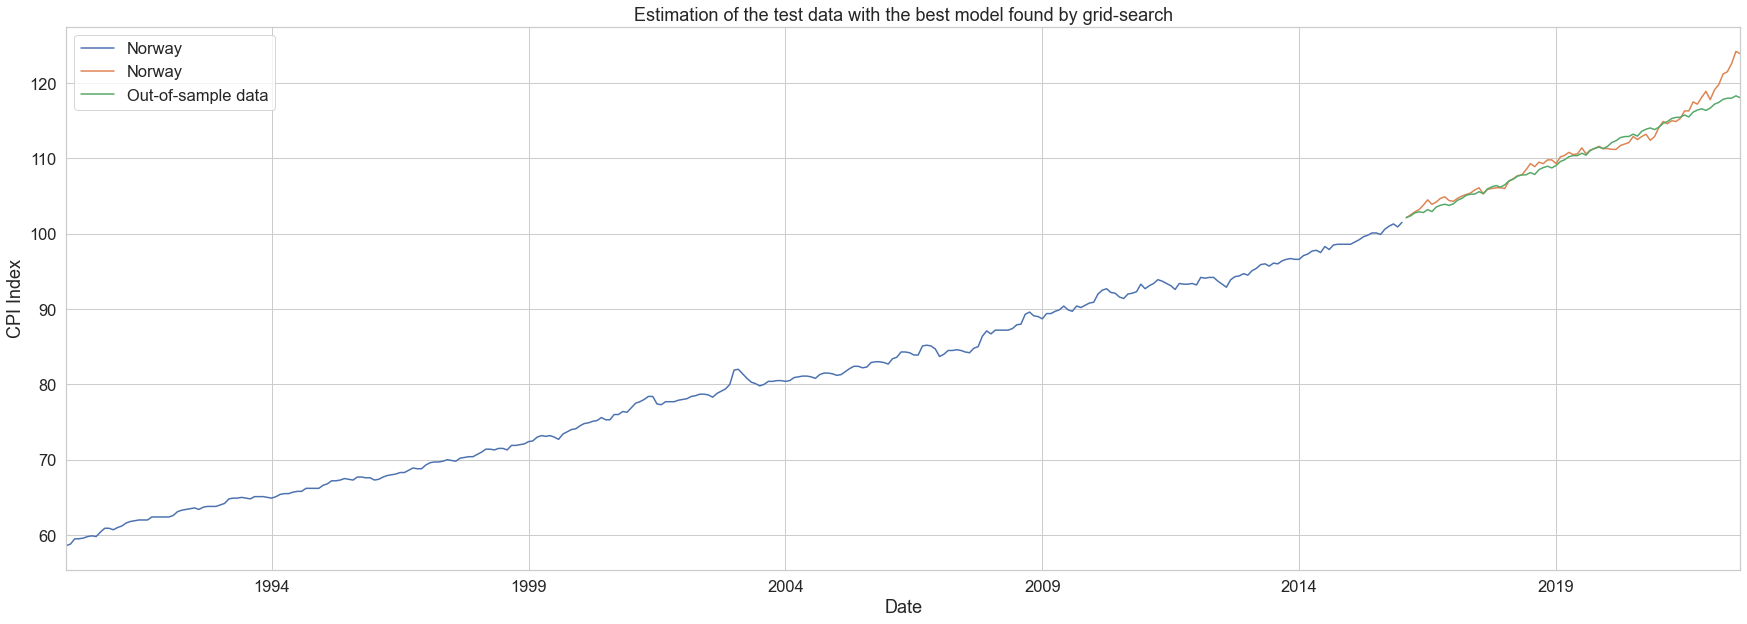

In [49]:
ax = ts.plot(figsize=(30, 10), legend=True)
ts_test.plot(ax=ax, legend=True)
preds.plot(ax=ax, legend=True)
ax.set_title('Estimation of the test data with the best model found by grid-search')
ax.set_xlabel('Date')
ax.set_ylabel('CPI Index')

In [50]:
metrics_summary(ts_test, preds)

MAPE: 0.007465754277231753
MAE: 0.8599603537228738
MSE: 2.052242818234937
RMSE: 1.432565118322702
R2: 0.9292612487695919


In the prediction plot, it is concluded that the model has a good forecasting property. However, it still exists some error, as previously referenced, because the last 2/2.5 years, the CPI Index goes from more or less linear trend to a quadratic one. As this change only appears in the test data, the model will always have difficulty in forecasting.

From the metrics assessed, the model seems to also have a good forecasting power, as the result MAPE error is low and and the MAE error has a value of almost one, which is small for the range of values presented in the CPI Index. Additionally, the R Squared metric is nearly at 1, meaning that the forecasted values almost perfectly fit the data.

### Exponential Smoothing

In [51]:
np.linspace(0, 1, 21)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [52]:
alphas = np.arange(0.05, 1, 0.05)
gammas = np.arange(0.05, 1, 0.05)
deltas = np.arange(0.05, 1, 0.05)

In [ ]:
results_es = pd.DataFrame()
count = 0
for alpha in alphas:
    for gamma in gammas:
        for delta in deltas:
            count += 1
            print(count, 'out of', len(alphas) * len(gammas) * len(deltas))
            model = ExponentialSmoothing(endog=ts_train, seasonal_periods=period, trend='additive', seasonal='additive', initialization_method='estimated')
            model_fitted = model.fit(
                smoothing_level=alpha,
                smoothing_trend=gamma,
                smoothing_seasonal=delta
            )
            preds = model_fitted.forecast(len(ts_val))
            mape = metrics.mean_absolute_percentage_error(ts_val, preds)
            res = {
                'alpha' : [alpha],
                'gamma' : gamma,
                'delta' : delta,
                'AIC' : model_fitted.aic,
                'MAPE' : mape
            }
            results_es = pd.concat([results_es, pd.DataFrame(res)], ignore_index=True)


In [78]:
best_es = results_es.loc[results_es.MAPE == results_es.MAPE.min()]
best_es

,alpha,gamma,delta,AIC,MAPE
19,0.05,0.1,0.05,1205.517582,0.136961


In [53]:
alpha = 0.05
gamma = 0.1
delta = 0.05

In [54]:
model = ExponentialSmoothing(endog=ts, seasonal_periods=period, trend='additive', seasonal='additive', initialization_method='estimated')
model_fitted = model.fit(
                smoothing_level=alpha,
                smoothing_trend=gamma,
                smoothing_seasonal=delta,
                optimized=True
            )

In [55]:
preds = model_fitted.forecast(len(ts_test))
preds.name = 'Predicted TS'

Text(0, 0.5, 'CPI Index')

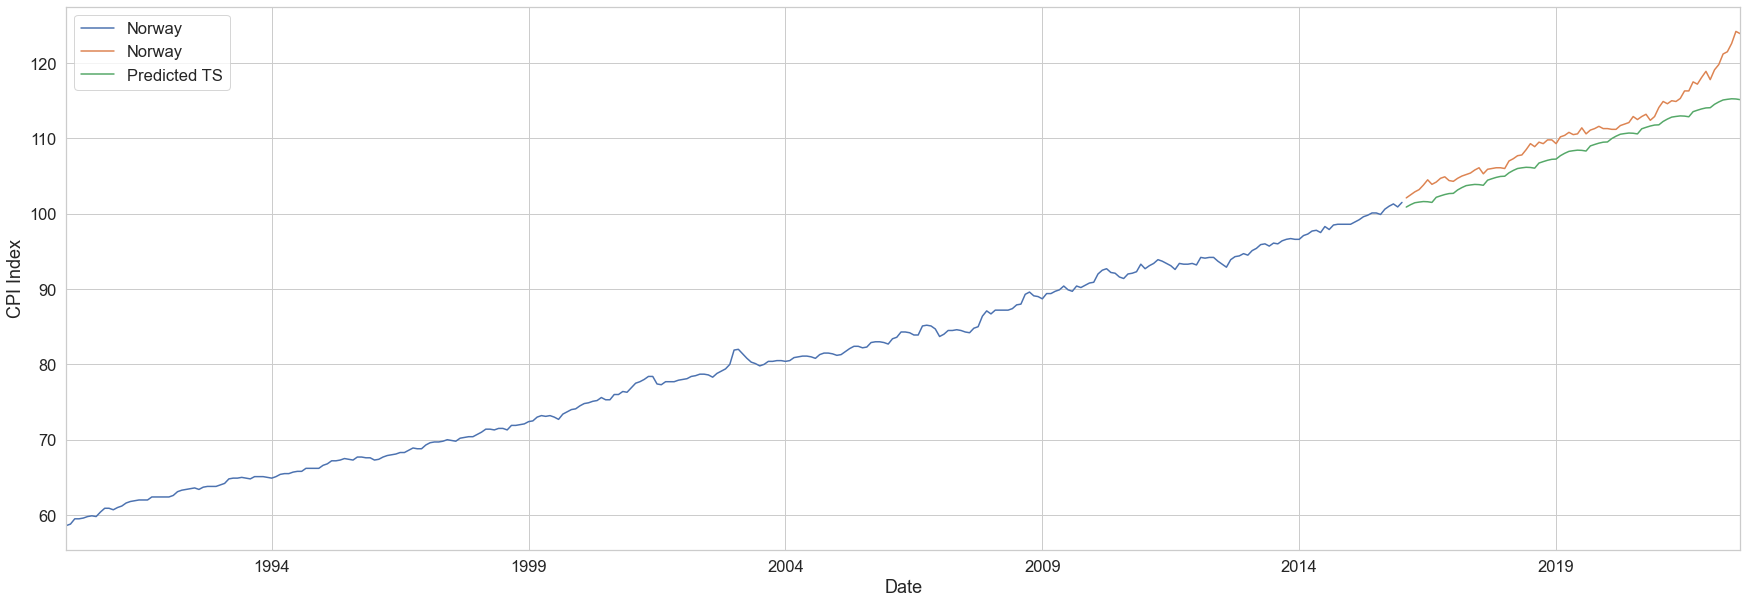

In [56]:
ax = ts.plot(figsize=(30, 10), legend=True)
ts_test.plot(ax=ax, legend=True)
preds.plot(ax=ax, legend=True)
ax.set_ylabel('CPI Index')

In [57]:
metrics_summary(ts_test, preds)

MAPE: 0.022234404030930233
MAE: 2.5107933157331077
MSE: 8.82085985178276
RMSE: 2.969993241033178
R2: 0.6959538095836945


From the exponential smoothing model's predictions image and the metrics attained, it is evident that the model has less predictive power than the SARIMA model. However, the metrics show that the model learns the data's major pattern, although not as much as the SARIMA model does.